## Import required libraries

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_hub as hub
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator, RegressorMixin



/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Load and preprocess the dataset

In [6]:
data_df = pd.read_csv("../Dataset/Apache.csv")

data_df.head()

,project_name,task_summary,task_type,priority,status,time_spent
0,ZooKeeper,Gia Lai - An Overview,Test,Major,Resolved,30240.0
1,ZooKeeper,Add document for snapshot compression config,Improvement,Minor,Closed,1330.0
2,ZooKeeper,Fix typo,Improvement,Minor,Resolved,1330.0
3,ZooKeeper,Playing Until Die,Bug,Major,Resolved,46080.0
4,ZooKeeper,"cleaning up the code,A static field should be ...",Improvement,Minor,Closed,30200.0


In [7]:
data_df.describe(include=np.object)

<ipython-input-7-5fc129dc0c45>:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data_df.describe(include=np.object)


,project_name,task_summary,task_type,priority,status
count,15524,15524,15524,15524,15524
unique,445,15385,23,14,3
top,Spark,Please add OWASP Dependency Check to the build...,Bug,Major,Closed
freq,764,15,7941,8280,8595


In [8]:
data_df.dtypes

project_name     object
task_summary     object
task_type        object
priority         object
status           object
time_spent      float64
dtype: object

In [9]:
data_df.describe()

,time_spent
count,1.552400e+04
mean,5.174191e+03
std,7.264950e+04
min,2.500000e-01
25%,6.000000e+01
50%,2.400000e+02
75%,1.530000e+03
max,5.241600e+06


In [10]:
def column_count(data_df):
  for col in data_df.columns:
    if((col == "_id") or (col == "time_spent")):
      pass
    else: 
      print('"{0}" column in data_df dataframe has {1} unique categories. \n'.format(col, data_df[col].nunique()))

  print('\ndata_df dataframe has {} unique records.'.format(len(data_df.index)))

In [11]:
print(column_count(data_df))

"project_name" column in data_df dataframe has 445 unique categories. 

"task_summary" column in data_df dataframe has 15385 unique categories. 

"task_type" column in data_df dataframe has 23 unique categories. 

"priority" column in data_df dataframe has 14 unique categories. 

"status" column in data_df dataframe has 3 unique categories. 


data_df dataframe has 15524 unique records.
None


### Data Cleansing

In [12]:
# Filter the DataFrame to only include rows with time_spent values
data_df = data_df.query('time_spent <= 180')

In [13]:
#Select features

col_info = {}

#Specify our text features

col_info['text_cols'] = [
     # Labeled Text features
     'task_summary'
]


col_info['cat_cols'] = [
    # Labeled categorical features
    'project_name',
    'task_type',
    'priority'
]

print('{:,} text features'.format(len(col_info['text_cols'])))
print('{:,} categorical features'.format(len(col_info['cat_cols'])))

1 text features
3 categorical features


In [14]:
#Define a function to draw boxplot for multiple categorical columns
def plot_boxplot_categorical(dataframe, columnSet):
  # Iterate over each categorical column and create a bar plot
  for column in columnSet:
      # Count the occurrences of each category
      counts = dataframe[column].value_counts()
      
      # Plot the bar chart
      plt.figure(figsize=(20, 6))
      plt.autoscale(enable=True, axis='x') 
      counts.plot(kind='bar')
      plt.title(f'Frequency of Categories in {column}')
      plt.xlabel(column)
      plt.ylabel('Frequency')
      plt.show()

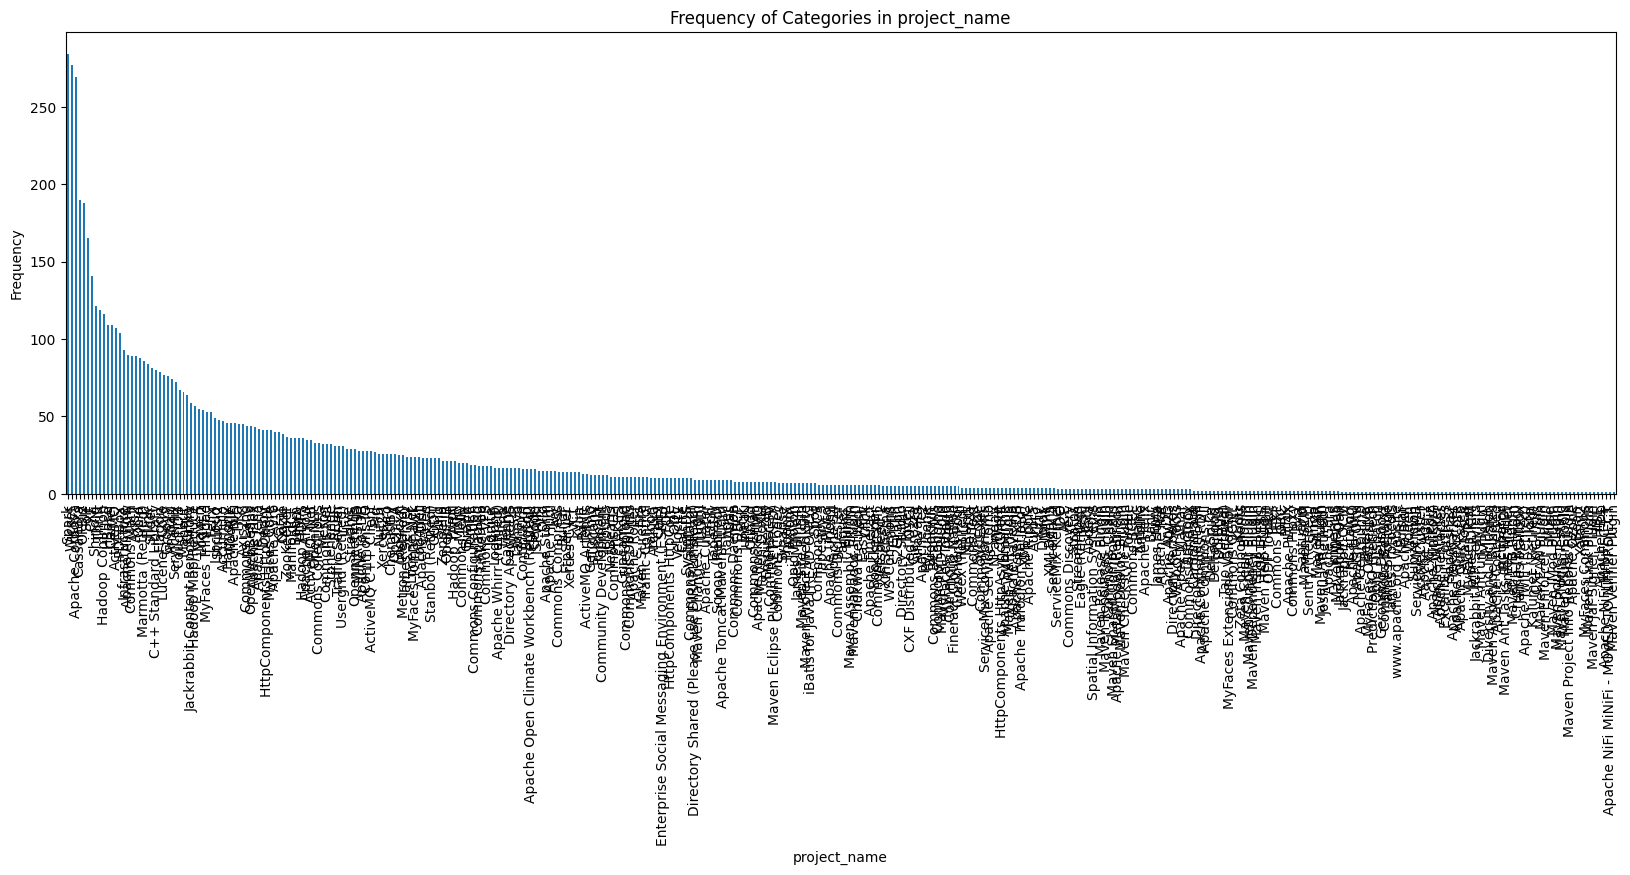

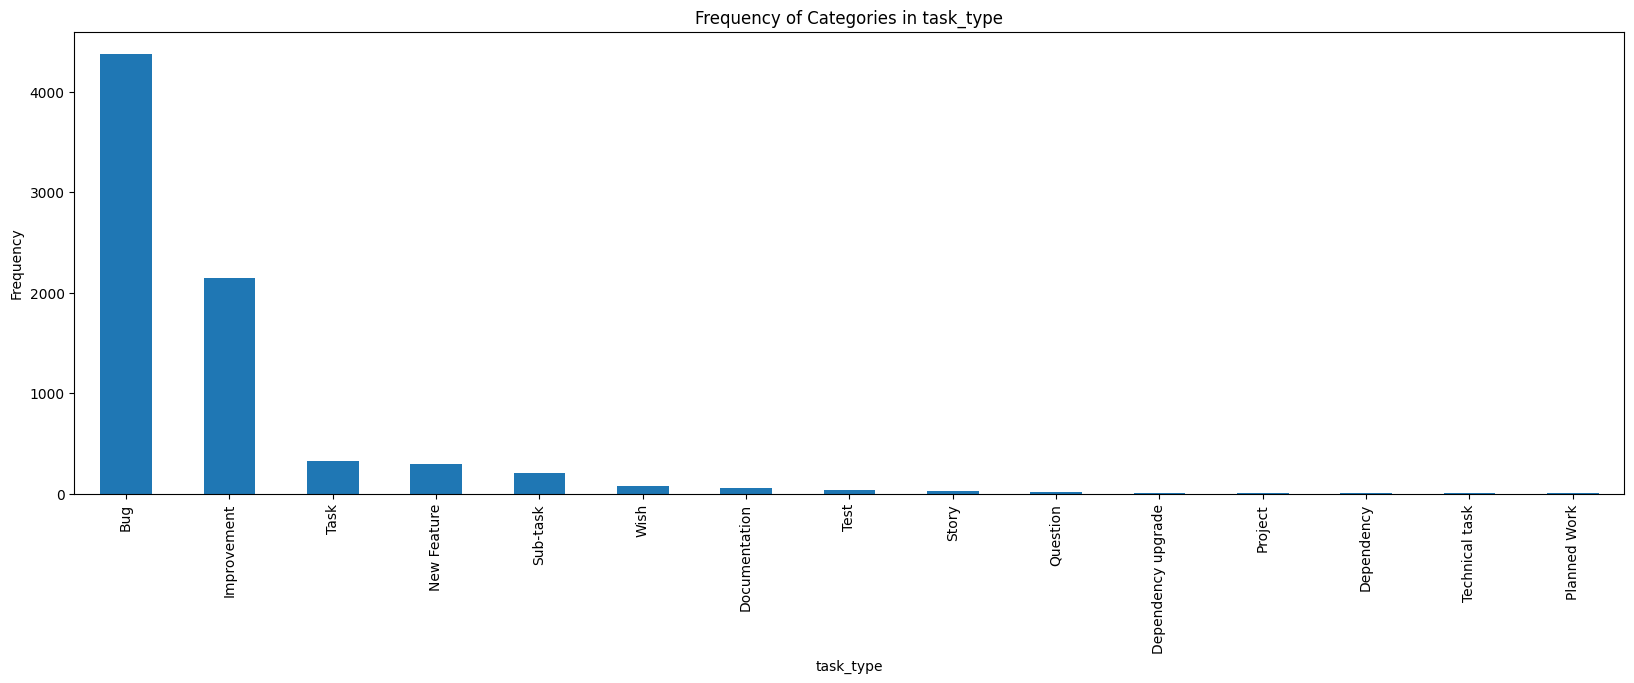

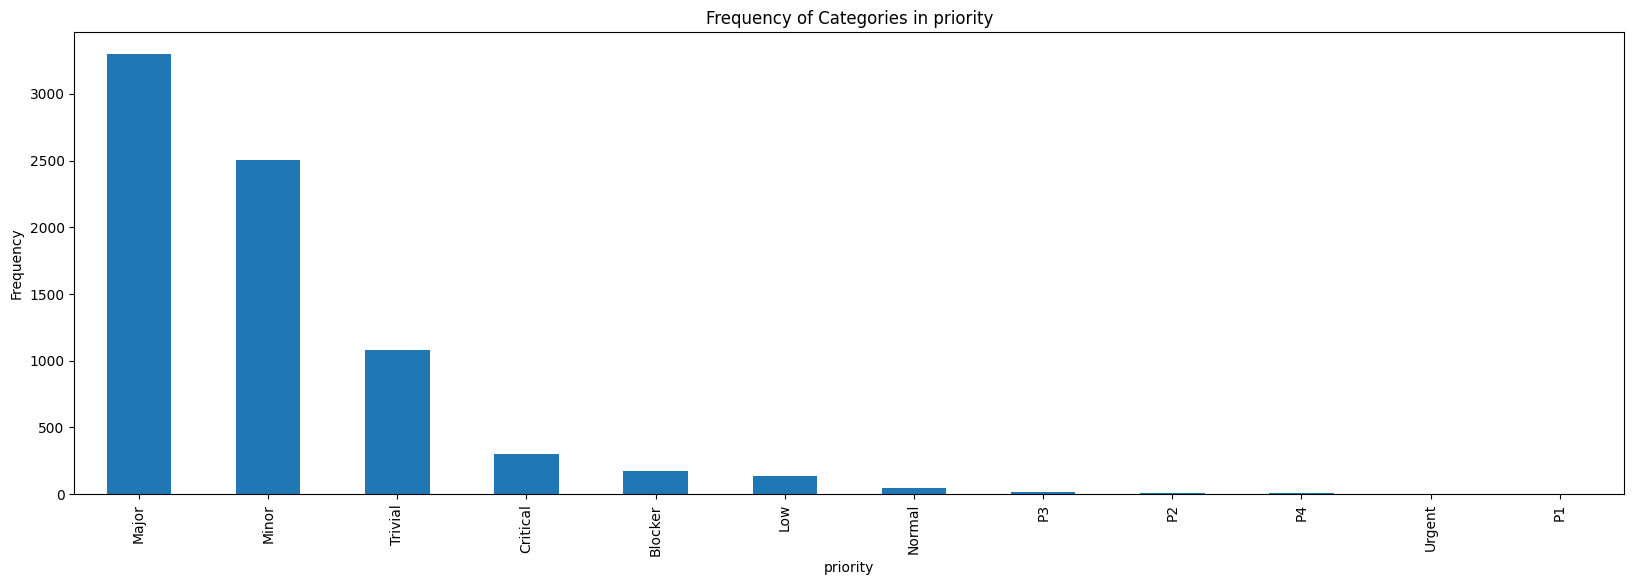

In [15]:
#Draw boxplot for all categorical data columns
plot_boxplot_categorical(data_df, col_info['cat_cols'])

In [16]:
print('The minimum count value threshold is {} for task_type column'.format(data_df.task_type.value_counts()['Sub-task']))
print('\nThe minimum count value threshold is {} for priority column'.format(data_df.priority.value_counts()['Normal']))

The minimum count value threshold is 207 for task_type column

The minimum count value threshold is 47 for priority column


#### Removing unwanted data in task_type column

In [17]:
# Define the categorical columns in your DataFrame
column = 'task_type'

# Set a threshold count for label values
threshold_count = 207

# Iterate over each categorical column and remove data records for specific label values
counts = data_df[column].value_counts()
infrequent_labels = counts[counts < threshold_count].index

# Remove data records for specific label values
data_df = data_df[~data_df[column].isin(infrequent_labels)]

# Reset the index of the updated data
data_df.reset_index(drop=True, inplace=True)

# Print deleted labels
print('This column has been removed - {}'.format(infrequent_labels.values))

This column has been removed - ['Wish' 'Documentation' 'Test' 'Story' 'Question' 'Dependency upgrade'
 'Project' 'Dependency' 'Technical task' 'Planned Work']


In [18]:
counts = data_df['task_type'].value_counts()
print(counts)

Bug            4378
Improvement    2142
Task            328
New Feature     291
Sub-task        207
Name: task_type, dtype: int64


#### Removing unwanted data in priority column

In [19]:
# Define the categorical columns in your DataFrame
column = 'priority'

# Set a threshold count for label values
threshold_count = 47

# Iterate over each categorical column and remove data records for specific label values
counts = data_df[column].value_counts()
infrequent_labels = counts[counts < threshold_count].index

# Remove data records for specific label values
data_df = data_df[~data_df[column].isin(infrequent_labels)]

# Reset the index of the updated data
data_df.reset_index(drop=True, inplace=True)

# Print deleted labels
print('This column has been removed - {}'.format(infrequent_labels.values))

This column has been removed - ['P3' 'P2' 'P4' 'Urgent' 'P1']


In [20]:
counts = data_df['priority'].value_counts()
print(counts)

Major       3217
Minor       2422
Trivial     1015
Critical     293
Blocker      172
Low          138
Normal        47
Name: priority, dtype: int64


In [21]:
print(column_count(data_df))

"project_name" column in data_df dataframe has 382 unique categories. 

"task_summary" column in data_df dataframe has 7248 unique categories. 

"task_type" column in data_df dataframe has 5 unique categories. 

"priority" column in data_df dataframe has 7 unique categories. 

"status" column in data_df dataframe has 3 unique categories. 


data_df dataframe has 7304 unique records.
None


In [22]:
#Define a function to draw boxplot for multiple categorical columns
def plot_boxplot_categorical(dataframe, columnSet):
  # Iterate over each categorical column and create a bar plot
  for column in columnSet:
      # Count the occurrences of each category
      counts = dataframe[column].value_counts()
      
      # Plot the bar chart
      plt.figure(figsize=(20, 6))
      plt.autoscale(enable=True, axis='x') 
      counts.plot(kind='bar')
      plt.title(f'Frequency of Categories in {column}')
      plt.xlabel(column)
      plt.ylabel('Frequency')
      plt.show()

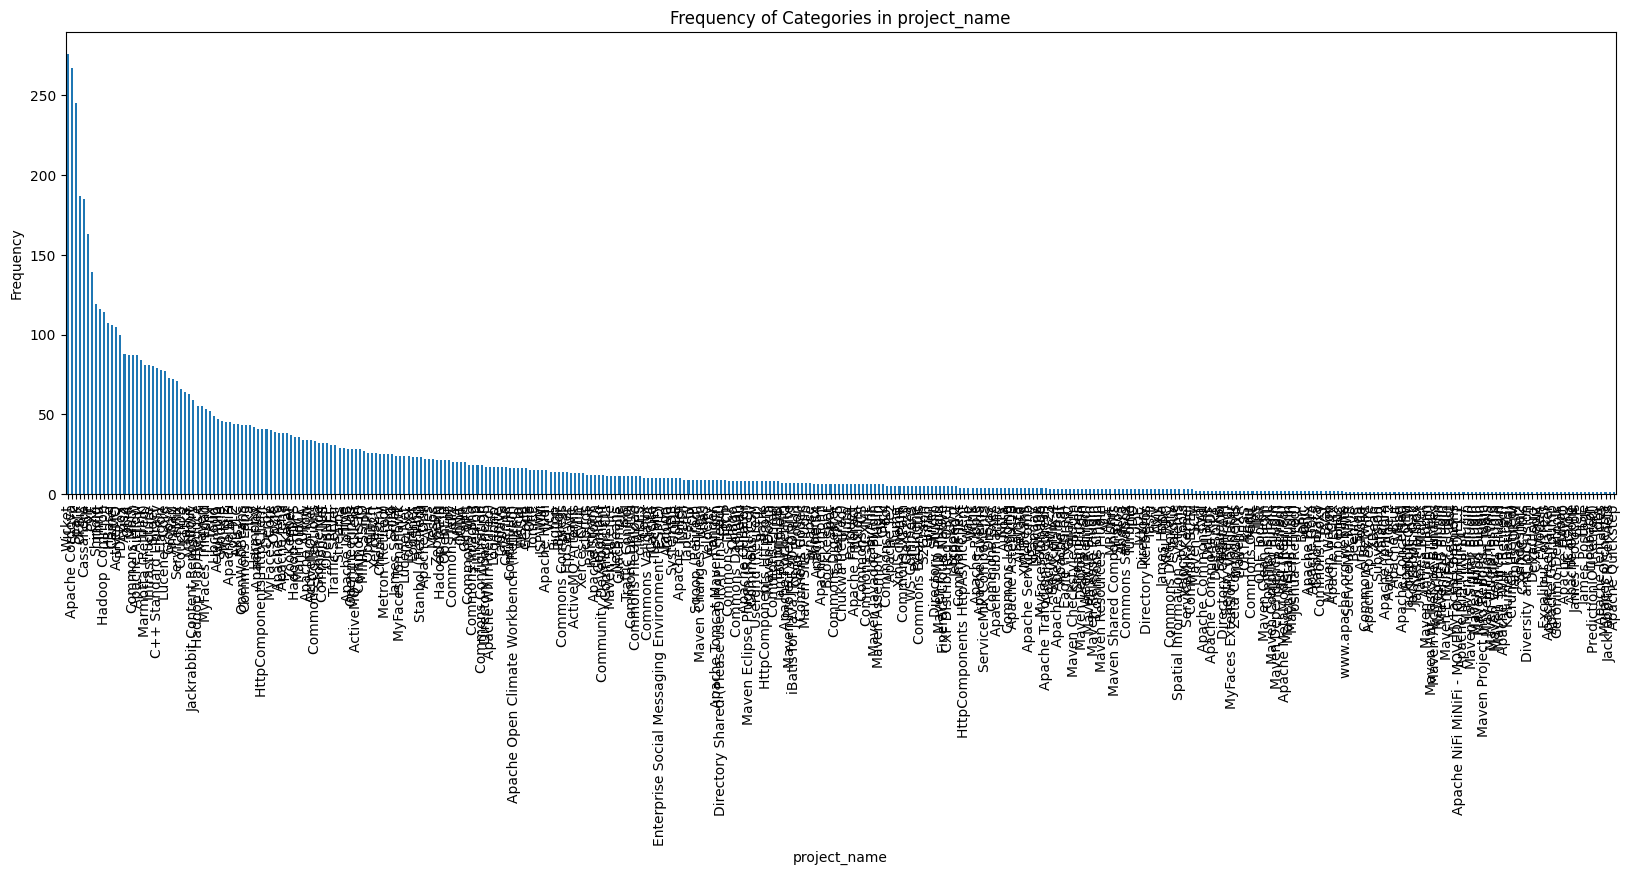

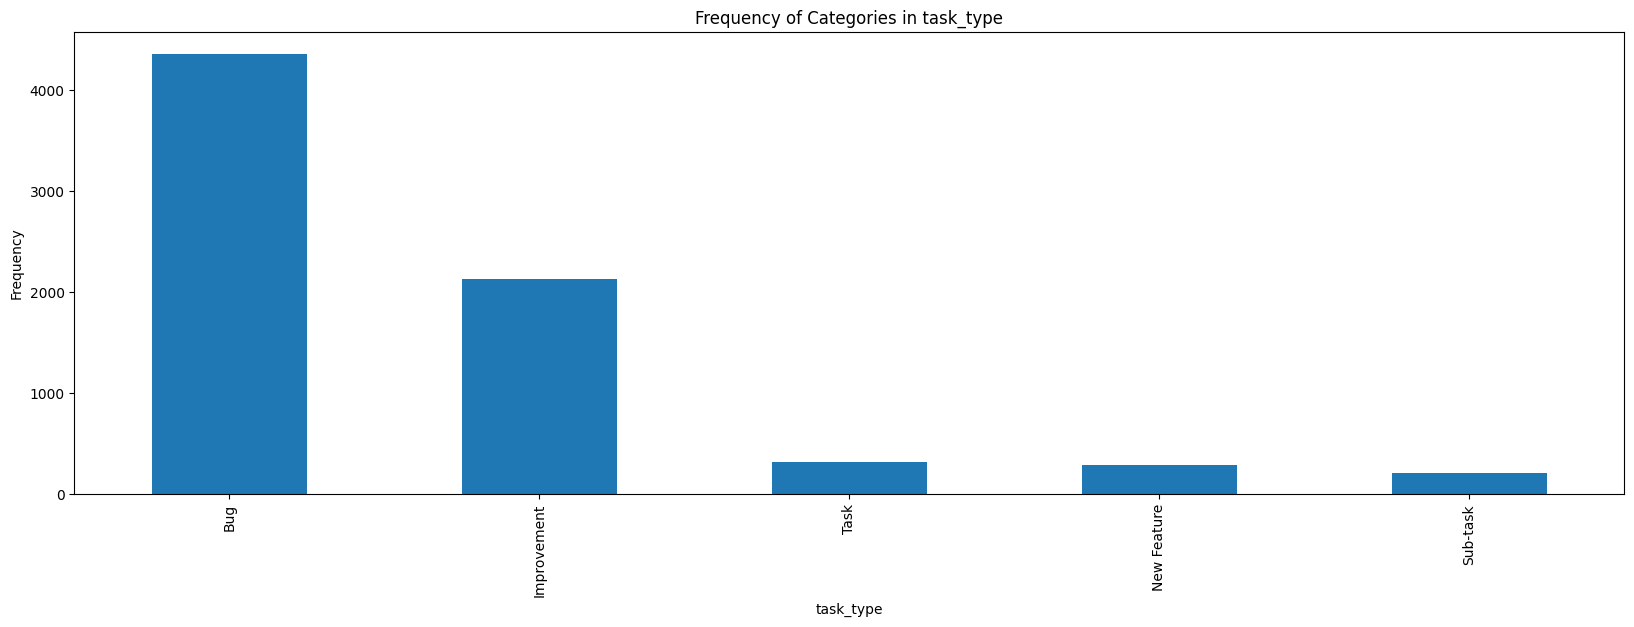

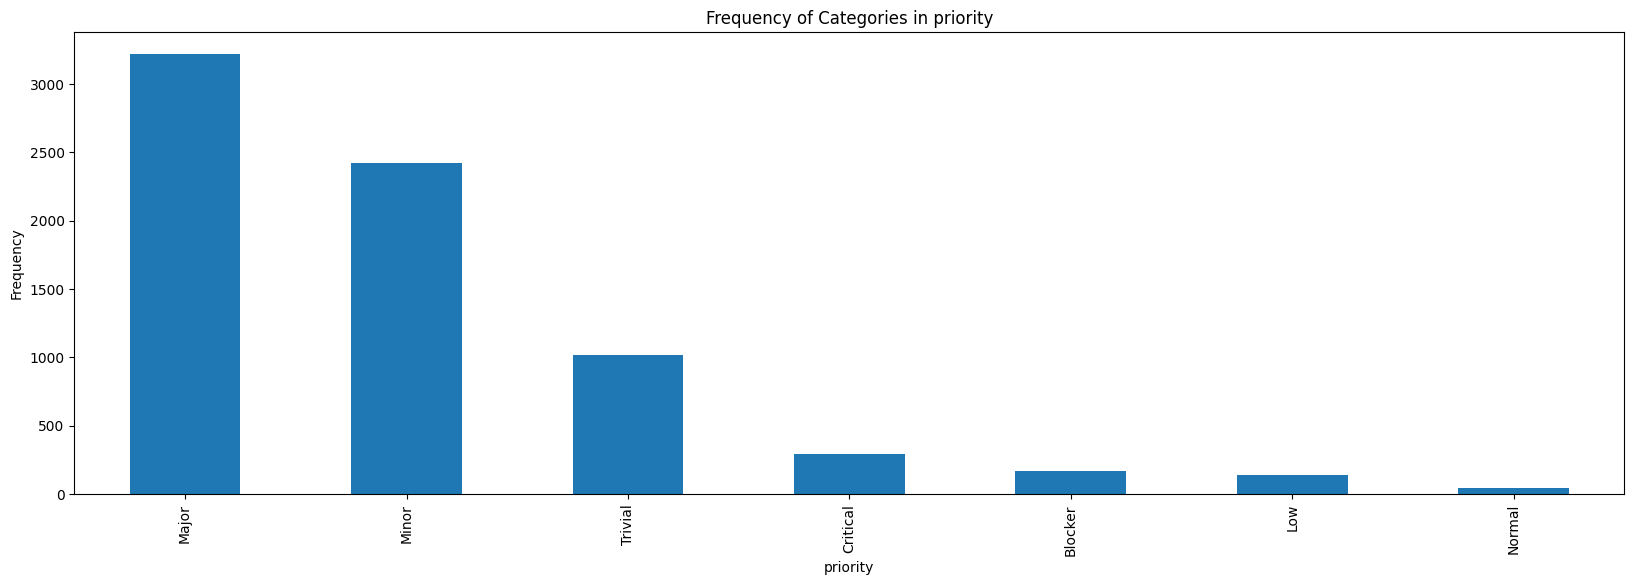

In [23]:
#Draw boxplot for all categorical data columns
plot_boxplot_categorical(data_df, col_info['cat_cols'])

#### Removing unwanted data in project_name column based on other input feature columns

In [24]:
# Group the data by project_name and count the number of task_summary per group
grouped_df = data_df.groupby('project_name').agg(task_count=('task_summary', 'count'))

# Get a boolean mask indicating which rows belong to projects with more than 49 task_summarys
mask = data_df['project_name'].isin(grouped_df[grouped_df['task_count'] > 49].index)

# Filter the original DataFrame using the mask
data_df = data_df[mask]

# Reset the index of the filtered DataFrame
data_df = data_df.reset_index(drop=True)

In [25]:
data_df['project_name'].value_counts()

Wicket                           276
Apache Cordova                   267
Spark                            245
OFBiz                            187
Cassandra                        185
Solr                             163
CXF                              139
Shindig                          119
Thrift                           116
Hadoop Common                    114
HBase                            107
Camel                            106
ActiveMQ                         105
PDFBox                           100
Axis2                             88
Apache Airflow                    87
Qpid                              87
Commons Math                      87
Flink                             84
Infrastructure                    81
Marmotta (Retired)                81
Slider                            80
C++ Standard Library              79
Flagon                            78
Lucene - Core                     77
Groovy                            73
Ambari                            72
S

In [26]:
print(column_count(data_df))

"project_name" column in data_df dataframe has 36 unique categories. 

"task_summary" column in data_df dataframe has 3808 unique categories. 

"task_type" column in data_df dataframe has 5 unique categories. 

"priority" column in data_df dataframe has 7 unique categories. 

"status" column in data_df dataframe has 2 unique categories. 


data_df dataframe has 3821 unique records.
None


In [27]:
grouped_df1 = data_df.groupby(['priority', 'task_type']).agg(task_count=('task_type', 'count'))
grouped_df1.head(100)

task_count
priority task_type              
Blocker  Bug                  78
         Improvement           3
         New Feature           1
         Sub-task              3
         Task                  5
Critical Bug                 133
         Improvement           7
         New Feature           2
         Sub-task              1
         Task                  6
Low      Bug                  69
         Improvement          64
         New Feature           3
         Sub-task              1
         Task                  1
Major    Bug                1028
         Improvement         324
         New Feature          62
         Sub-task             87
         Task                 86
Minor    Bug                 660
         Improvement         494
         New Feature          68
         Sub-task             22
         Task                 30
Normal   Bug                  38
         Improvement           6
         New Feature           2
         Task                  1
Trivial  Bug                 240
         Improvement         252
         New Feature          10
         Sub-task             10
         Task                 24

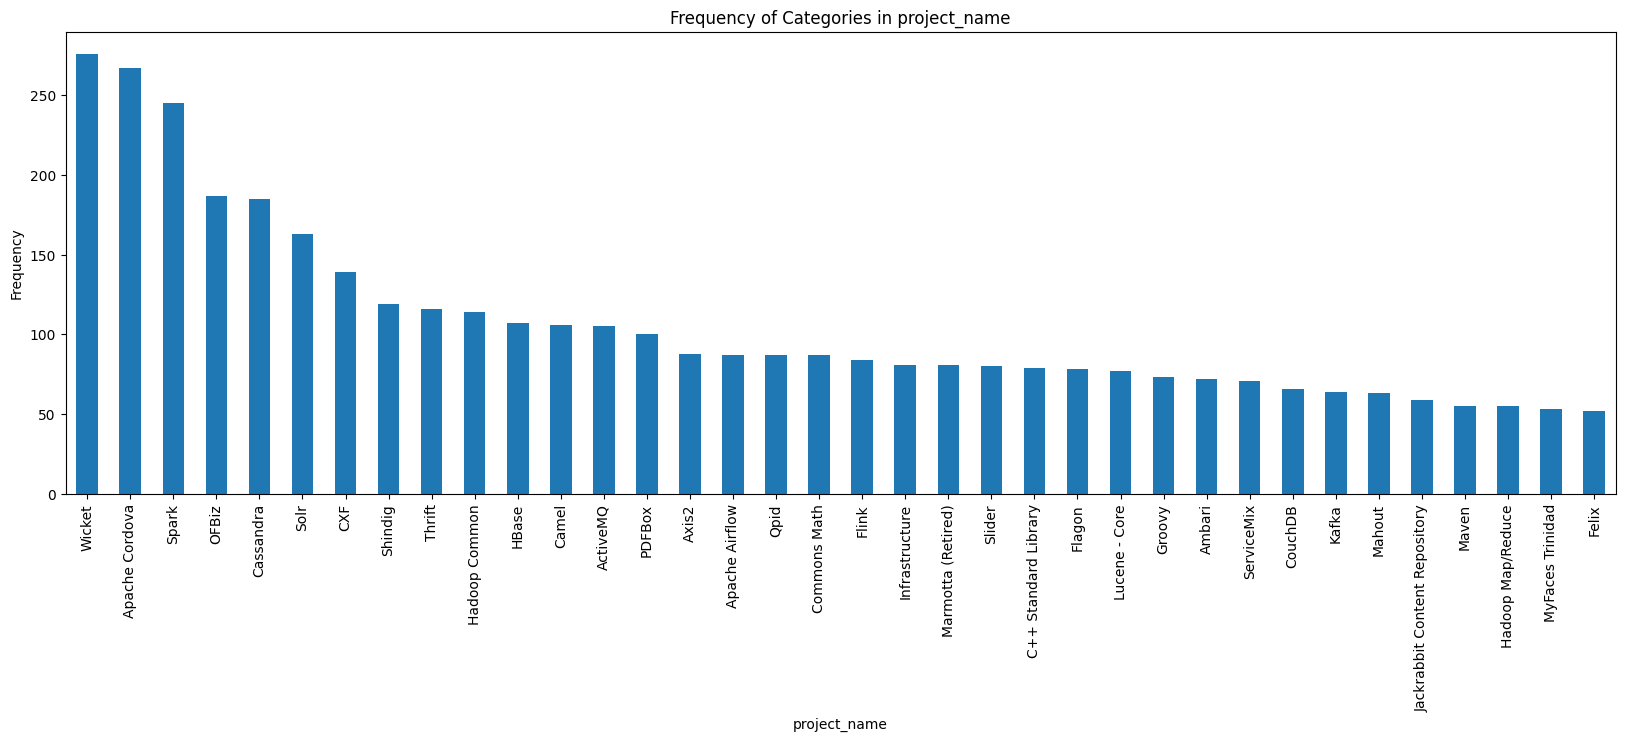

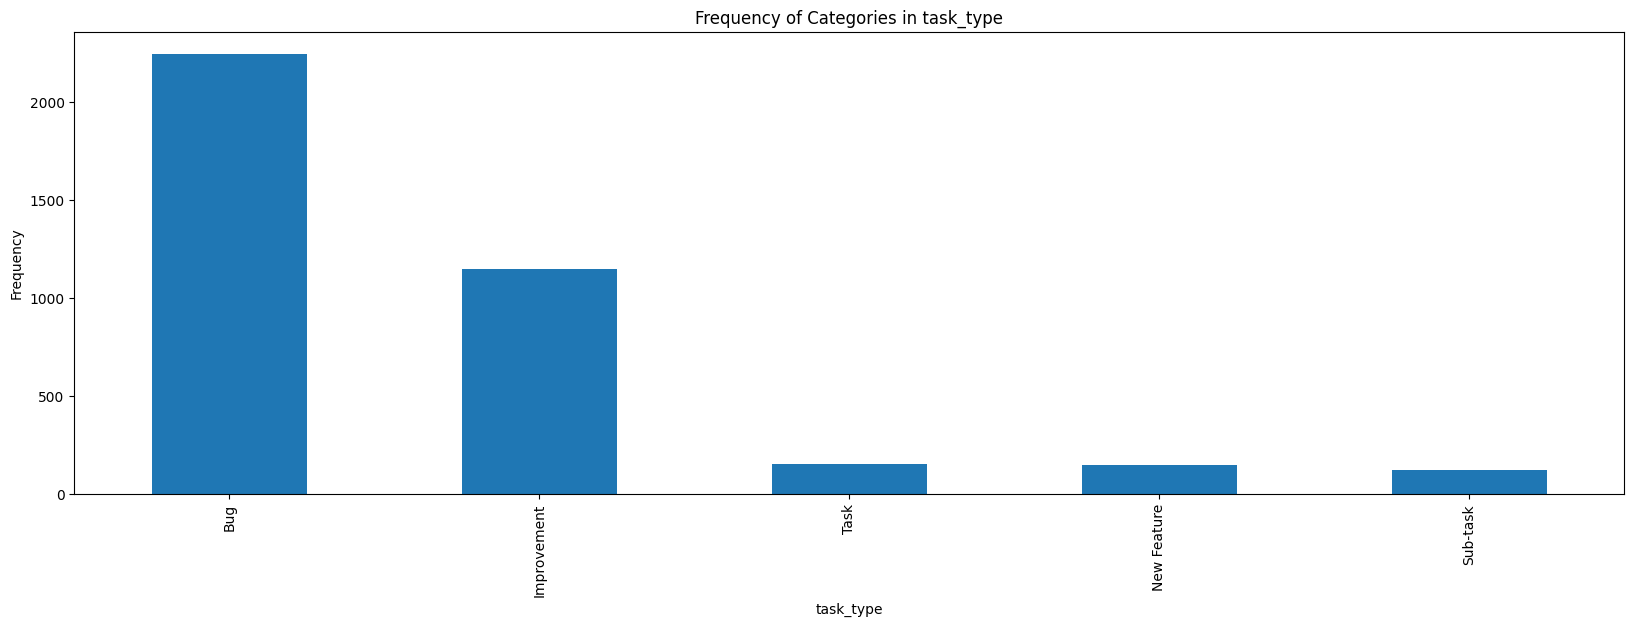

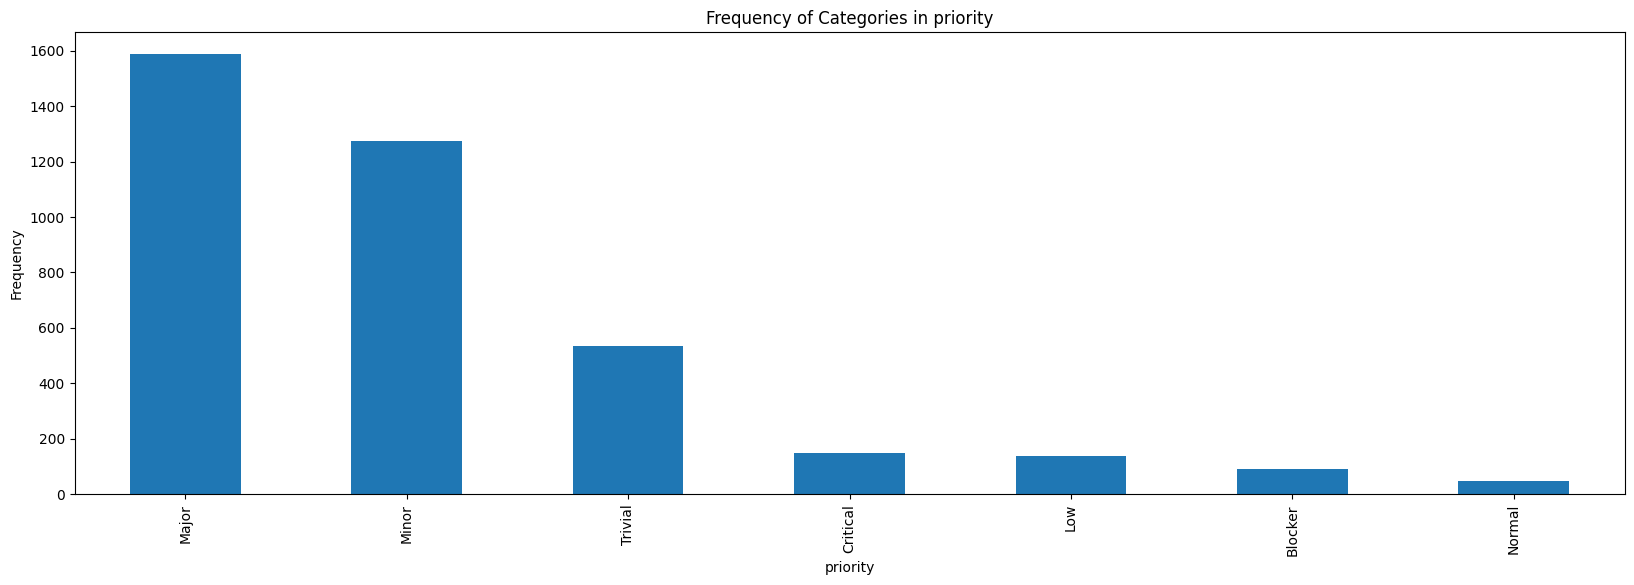

In [28]:
#Draw boxplot for all categorical data columns
plot_boxplot_categorical(data_df, col_info['cat_cols'])

#### Removing imbalance data in time_spent column

In [29]:
print('Time spent')
print('Min : ',data_df['time_spent'].min())
print('Median : ',data_df['time_spent'].median())
print('Max : ',data_df['time_spent'].max())

Time spent
Min :  0.25
Median :  60.0
Max :  180.0


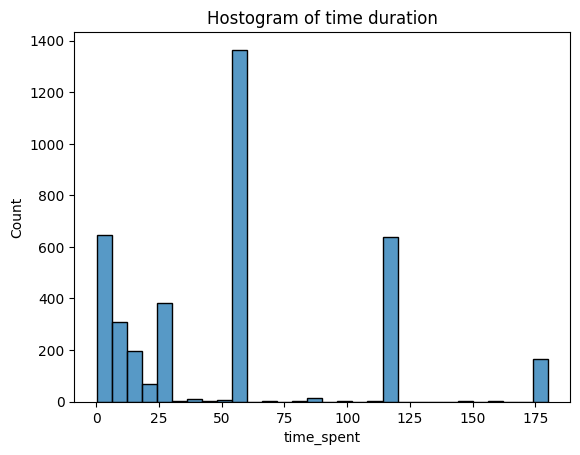

In [30]:
all_time_spent = data_df['time_spent']


#Plot a histogram of the time spent
ax= sns.histplot(all_time_spent, bins=30)

t=ax.set_title('Hostogram of time duration')

In [31]:
#Define a function to draw boxplot
def plot_boxplot(dataframe, column):
  dataframe.boxplot(column=[column])
  plt.grid(False)
  plt.show()

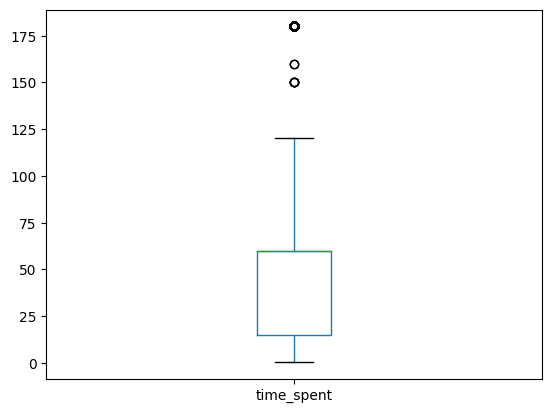

In [32]:
#Draw boxplot for time spent
plot_boxplot(data_df, "time_spent")

In [33]:
###Interquartile Range (IQR) Method:####
# Calculate the IQR for the task duration column
Q1 = data_df['time_spent'].quantile(0.25)
Q3 = data_df['time_spent'].quantile(0.75)
IQR = Q3 - Q1

# Remove the outliers from the dataset
data_df = data_df[(data_df['time_spent'] >= Q1 - 1.5*IQR) & (data_df['time_spent'] <= Q3 + 1.5*IQR)]

# Reset the index of the filtered DataFrame
data_df = data_df.reset_index(drop=True)

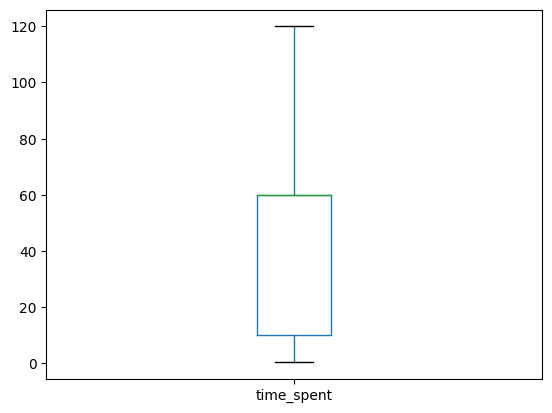

In [34]:
#Draw boxplot for time spent
plot_boxplot(data_df, "time_spent")

In [35]:
print(column_count(data_df))

"project_name" column in data_df dataframe has 36 unique categories. 

"task_summary" column in data_df dataframe has 3640 unique categories. 

"task_type" column in data_df dataframe has 5 unique categories. 

"priority" column in data_df dataframe has 7 unique categories. 

"status" column in data_df dataframe has 2 unique categories. 


data_df dataframe has 3649 unique records.
None


In [36]:
data_df.time_spent.describe()

count    3649.000000
mean       49.989161
std        39.360903
min         0.250000
25%        10.000000
50%        60.000000
75%        60.000000
max       120.000000
Name: time_spent, dtype: float64

In [37]:
grouped_df1 = data_df.groupby(['priority', 'task_type']).agg(task_count=('task_type', 'count'))
grouped_df1.head(100)

task_count
priority task_type              
Blocker  Bug                  73
         Improvement           3
         New Feature           1
         Sub-task              1
         Task                  4
Critical Bug                 126
         Improvement           7
         New Feature           2
         Sub-task              1
         Task                  6
Low      Bug                  69
         Improvement          64
         New Feature           3
         Sub-task              1
         Task                  1
Major    Bug                 972
         Improvement         307
         New Feature          57
         Sub-task             73
         Task                 79
Minor    Bug                 637
         Improvement         469
         New Feature          65
         Sub-task             20
         Task                 29
Normal   Bug                  38
         Improvement           6
         New Feature           2
         Task                  1
Trivial  Bug                 240
         Improvement         249
         New Feature           9
         Sub-task             10
         Task                 24

In [38]:
#Define a function to draw boxplot for multiple categorical columns
def plot_boxplot_categorical(dataframe, columnSet):
  # Iterate over each categorical column and create a bar plot
  for column in columnSet:
      # Count the occurrences of each category
      counts = dataframe[column].value_counts()
      
      # Plot the bar chart
      plt.figure(figsize=(20, 6))
      plt.autoscale(enable=True, axis='x') 
      counts.plot(kind='bar')
      plt.title(f'Frequency of Categories in {column}')
      plt.xlabel(column)
      plt.ylabel('Frequency')
      plt.show()

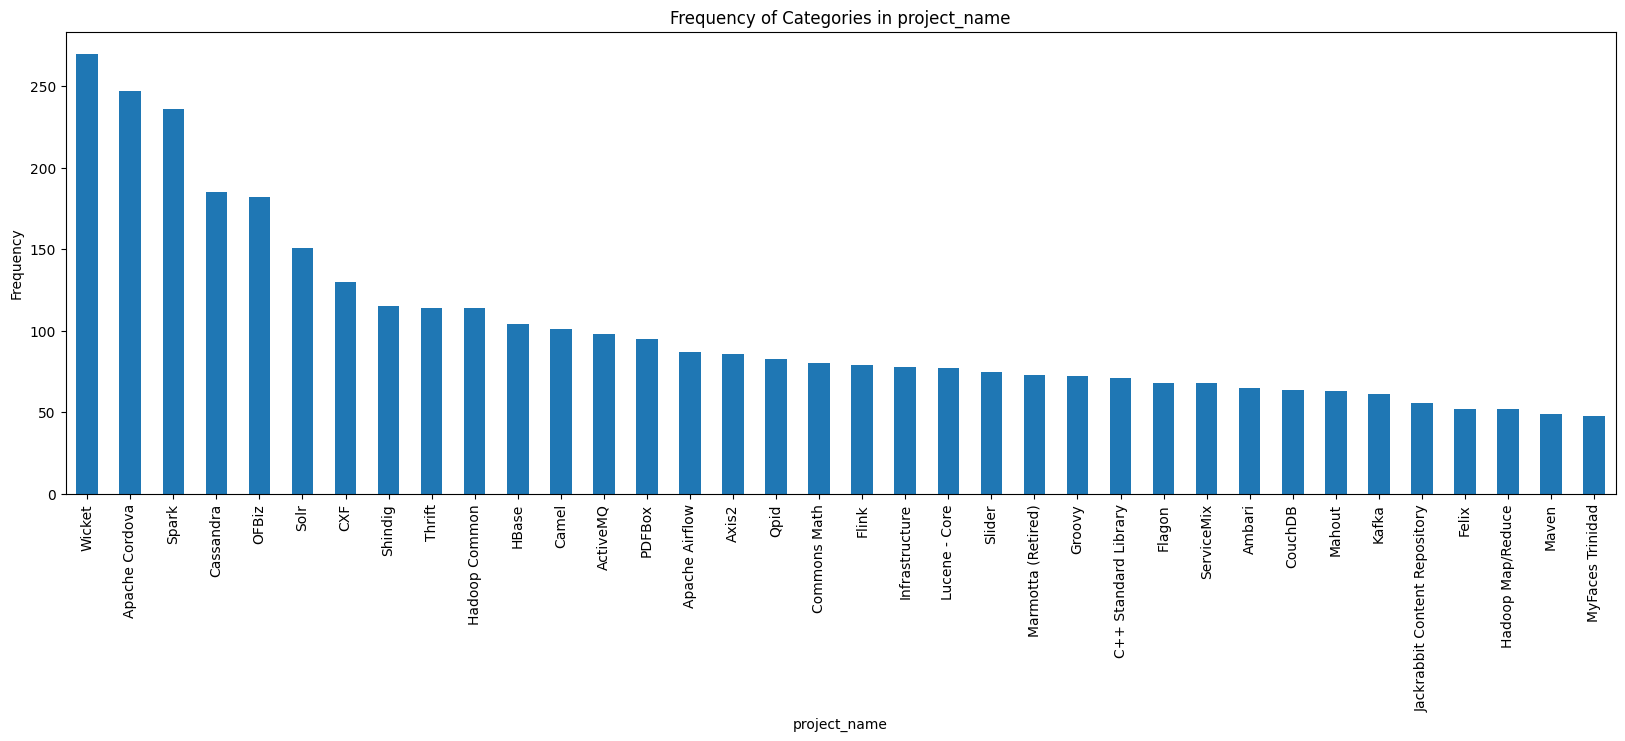

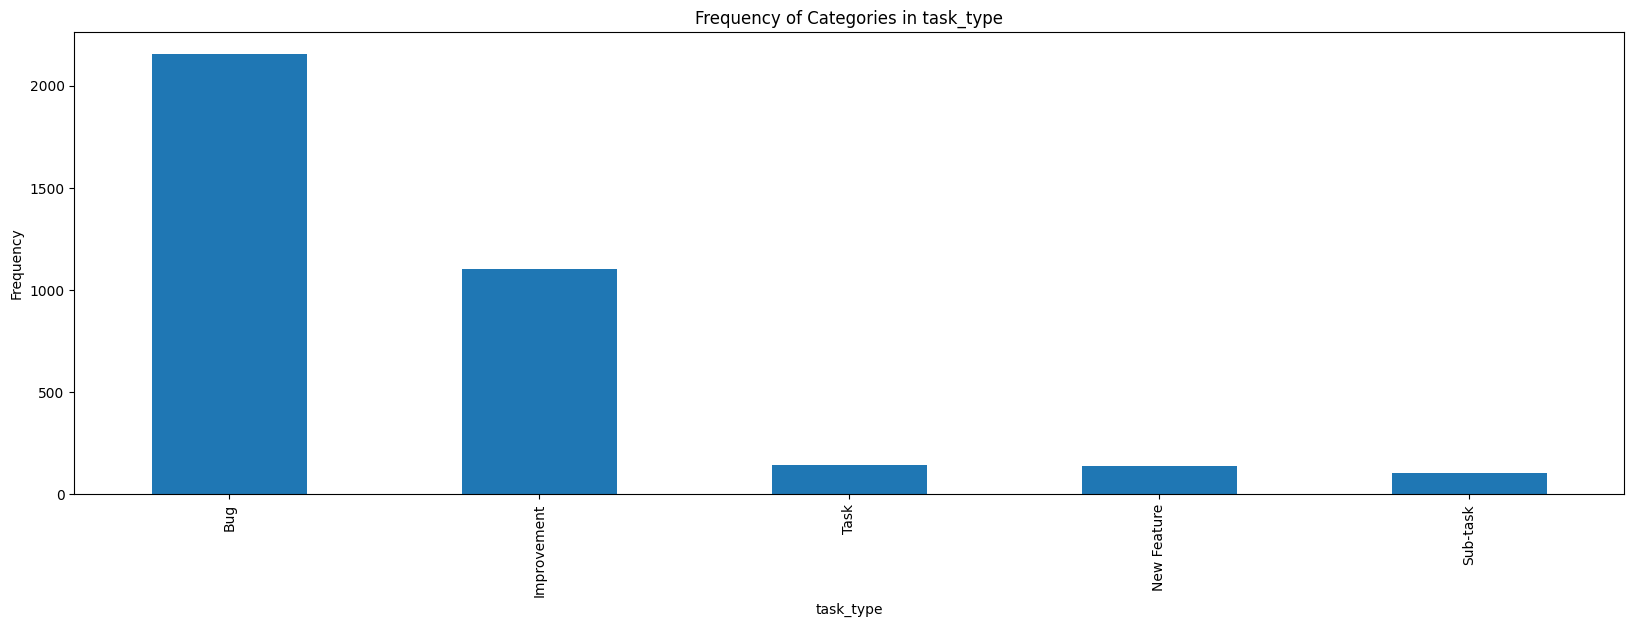

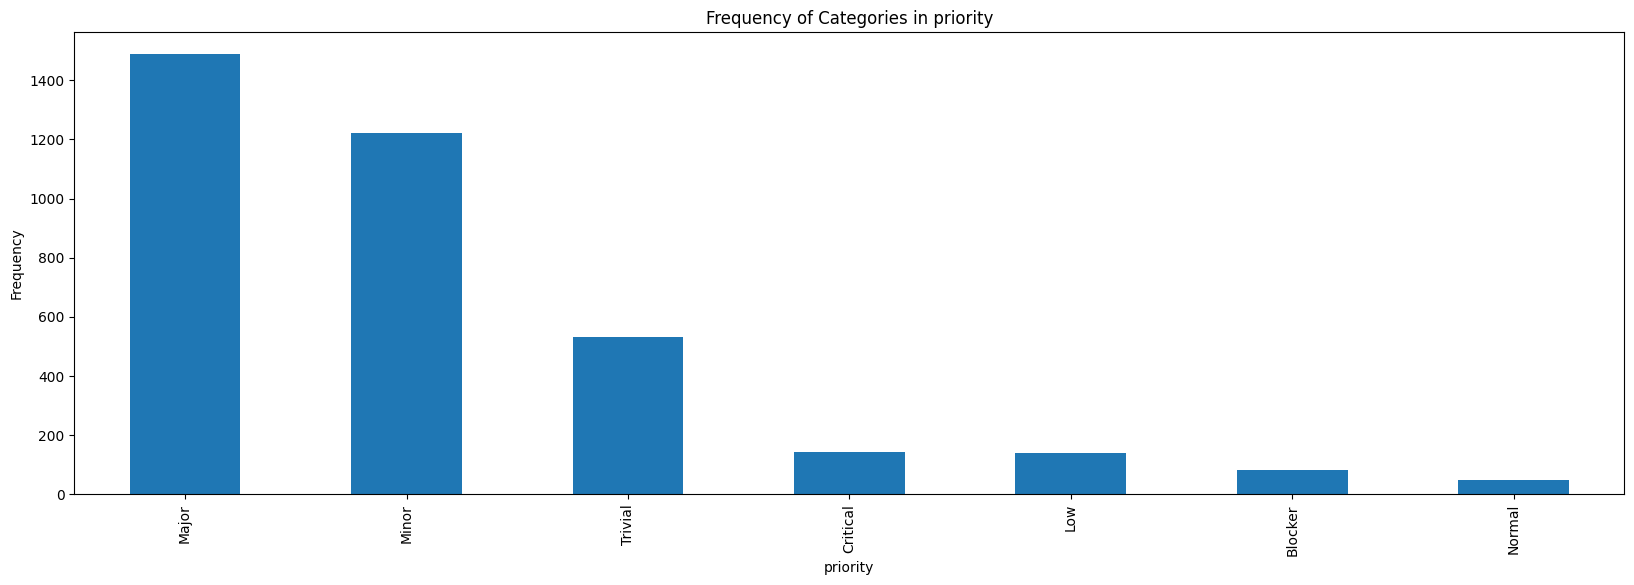

In [39]:
#Draw boxplot for all categorical data columns
plot_boxplot_categorical(data_df, col_info['cat_cols'])

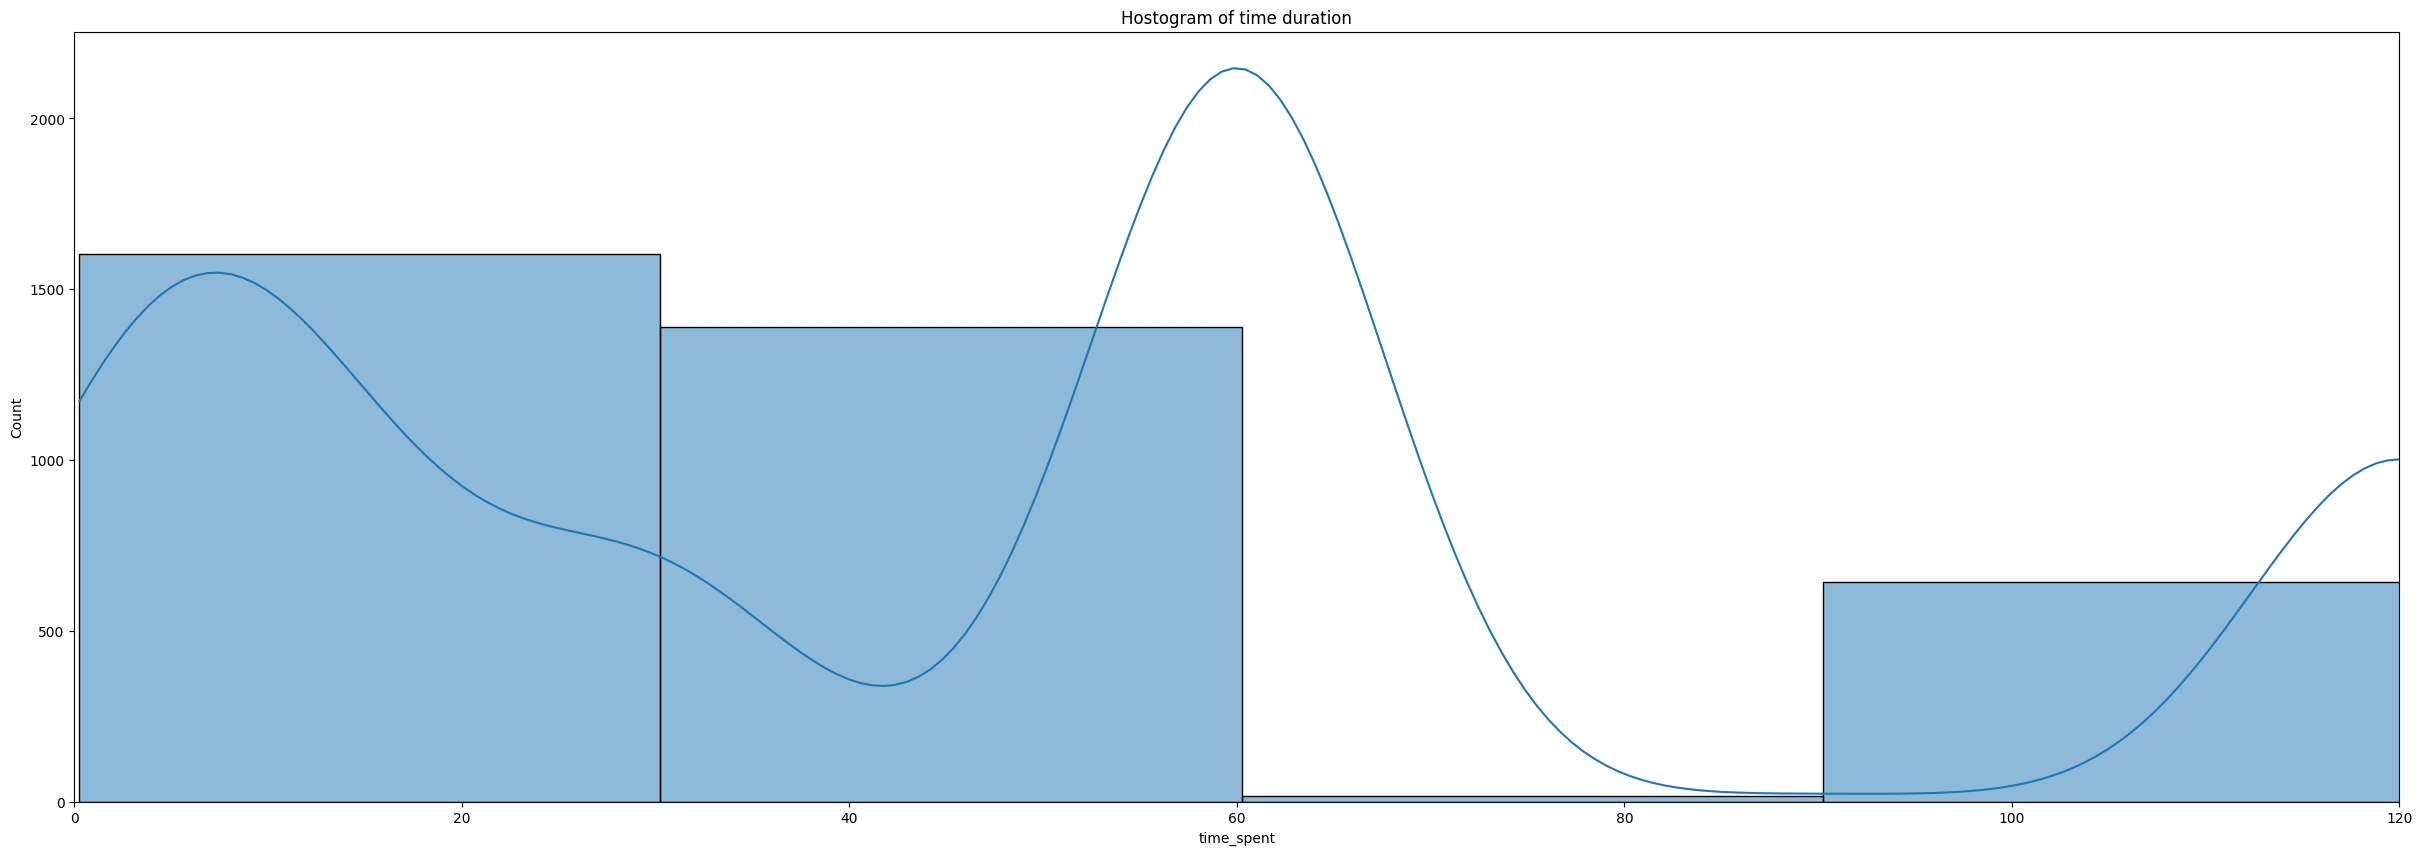

In [40]:
all_time_spent = data_df['time_spent']


fig, ax = plt.subplots(figsize = (30,10))
sns.histplot(all_time_spent, ax=ax, binwidth=30, bins=10, kde=True)
ax.set_xlim(0, 120)
ax.set_title('Hostogram of time duration')
plt.show()

### Data Encoding - Performing label encoding for categorical data columns

In [41]:
 #Disable those pesky "SettingWithCopyWarning" messages
pd.options.mode.chained_assignment = None #default='warn'

print('Converting selectted categorical features to integers...')

#For each of the categorical features...
for col_name in col_info['cat_cols']:

    #Get the number of unique values for this category.
    num_unique = len(data_df[col_name].unique())

    #If there are more than two, warn about it.
    if num_unique > 2:
        print('Note! Column "{:}" has {:,} possible values.'.format(col_name,num_unique))

    #First, change the type of the specified columns to "catogory". This will assign a "code" to each unique category
    data_df[col_name] = data_df[col_name].astype('category')

    #Second, replace the strings with their code values.
    data_df[col_name] = data_df[col_name].cat.codes.astype('float') + 1


print('DONE')

Converting selectted categorical features to integers...
Note! Column "project_name" has 36 possible values.
Note! Column "task_type" has 5 possible values.
Note! Column "priority" has 7 possible values.
DONE


In [42]:
# Display the category columns after the transformation.
data_df[col_info['cat_cols']].head()

,project_name,task_type,priority
0,36.0,1.0,4.0
1,36.0,2.0,7.0
2,36.0,1.0,5.0
3,36.0,1.0,4.0
4,36.0,1.0,5.0


#### Define the columns for text, numerical, and categorical features

In [43]:
text_columns = ['task_summary']
numerical_columns = ['project_name', 'task_type', 'priority']

In [44]:
data_df.head()

,project_name,task_summary,task_type,priority,status,time_spent
0,36.0,Links to examples in documentation points to o...,1.0,4.0,Resolved,60.0
1,36.0,CookieUtils save method: incomplete javadoc,2.0,7.0,Resolved,15.0
2,36.0,CSPDirective is missing worker-src,1.0,5.0,Resolved,2.0
3,36.0,res/modal.js using aria-labelledby where it sh...,1.0,4.0,Resolved,60.0
4,36.0,FileUpload serialization error,1.0,5.0,Resolved,60.0


#### Text Data Pre-processing

In [45]:
# Load the Universal Sentence Encoder
use_model_url = "https://tfhub.dev/google/universal-sentence-encoder-large/5"
use_model = hub.load(use_model_url)

In [46]:
# Separate the input features and target variable
X_text = data_df["task_summary"].values
X_numerical = data_df[["project_name", "task_type", "priority"]].values
y = data_df["time_spent"].values

In [47]:
# Split the data into train and test sets
X_text_train, X_text_test, X_numerical_train, X_numerical_test, y_train, y_test = train_test_split(
    X_text, X_numerical, y, test_size=0.2, shuffle=True, random_state=42)

In [48]:
# Function to wrap the USE model call and convert the result to a NumPy array
def use_encode(text):
    return use_model(text).numpy()

# Encode the text data using USE
X_text_train_embed = tf.py_function(use_encode, [X_text_train], tf.float32)
X_text_test_embed = tf.py_function(use_encode, [X_text_test], tf.float32)

### Data Scaling

In [49]:
scaler = MinMaxScaler()

# Normalize the numerical features
X_numerical_train_scaled = scaler.fit_transform(X_numerical_train)
X_numerical_test_scaled = scaler.transform(X_numerical_test)

# Normalize the target variable
y_train = scaler.fit_transform(y_train.reshape(-1, 1))
y_test = scaler.transform(y_test.reshape(-1, 1))

In [50]:
# Concatenate the encoded text features and numerical(catogorical) features
X_train = np.concatenate([X_text_train_embed, X_numerical_train_scaled], axis=1)
X_test = np.concatenate([X_text_test_embed, X_numerical_test_scaled], axis=1)

## Model Creation

### Nural Network Model

#### Model Creation

In [51]:
# Build the regression model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])

In [52]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               66048     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 74,369
Trainable params: 74,369
Non-trainable params: 0
_________________________________________________________________


In [53]:
# Define the learning rate and optimizer
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate)

In [54]:
custom_callbacks = EarlyStopping(monitor='val_loss',
                   mode='min',
                   patience=50,
                   restore_best_weights = True,
                   start_from_epoch=0)

#### Model Training

In [55]:
import tensorflow_addons as tfa

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[
        tf.keras.metrics.RootMeanSquaredError(name="root_mean_squared_error", dtype=None),
        tfa.metrics.RSquare(name='r_square', dtype=tf.float32, multioutput='uniform_average', num_regressors=1),
        tf.keras.losses.CosineSimilarity(axis=1, reduction=tf.keras.losses.Reduction.SUM, name='cosine_similarity')
    ])

In [66]:
class PrintTrainingDataCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print("Epoch", epoch+1)
        print("Train loss:", logs['loss'])
        print("Train RMSE:", logs['root_mean_squared_error'])
        print("Train R^2:", logs['r_square'])
        print()

# Train the model
batch_size = 32
epochs = 1000
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs, callbacks=[custom_callbacks, PrintTrainingDataCallback()], verbose=0)

Epoch 1
Train loss: 0.0002445194113533944
Train RMSE: 0.015637116506695747
Train R^2: 0.9977173805236816

Epoch 2
Train loss: 0.00032278531580232084
Train RMSE: 0.01796622760593891
Train R^2: 0.9969868063926697

Epoch 3
Train loss: 0.000515013060066849
Train RMSE: 0.022693898528814316
Train R^2: 0.995192289352417

Epoch 4
Train loss: 0.0008030545432120562
Train RMSE: 0.028338216245174408
Train R^2: 0.9925034046173096

Epoch 5
Train loss: 0.0007106378325261176
Train RMSE: 0.026657789945602417
Train R^2: 0.9933661222457886

Epoch 6
Train loss: 0.000585236179176718
Train RMSE: 0.024191655218601227
Train R^2: 0.994536817073822

Epoch 7
Train loss: 0.0004581557004712522
Train RMSE: 0.02140457183122635
Train R^2: 0.9957230687141418

Epoch 8
Train loss: 0.0003786511078942567
Train RMSE: 0.019458958879113197
Train R^2: 0.996465265750885

Epoch 9
Train loss: 0.00024392610066570342
Train RMSE: 0.01561813335865736
Train R^2: 0.9977229237556458

Epoch 10
Train loss: 0.00018723317771218717
Train RM

#### Model Evaluation

In [67]:
# Predict the target variable
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r_square = model.evaluate(X_test, y_test)[1]  # Get the R-squared value from the metrics
print('Mean Squared Error:', mse)
print('R-squared:', r_square)

23/23 [===============================] - 0s 3ms/step - loss: 0.1080 - root_mean_squared_error: 0.0462 - r_square: 0.7256 - cosine_similarity: -31.7391
Mean Squared Error: 0.0462183579904672
R-squared: 0.7256614418029785


In [95]:
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,20), facecolor='#F0F0F0')
        #plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('Model '+ title)
    ax.set_ylabel(title)
    ax.set_ylim(0,0.3)
    ax.set_xlabel('Epoch')
    ax.legend(['train', 'validation'])

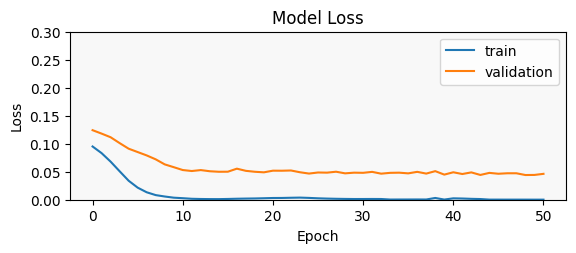

In [96]:
display_training_curves(history.history['loss'][1:], history.history['val_loss'][1:], 'Loss', 212)

## Task Duration Prediction

In [98]:
# Make a prediction for a new task
new_task = pd.DataFrame({
    'project_name': 'Apache Cordova',
    'task_type': 'Bug',
    'priority': 'Major',
    'task_summary': 'Problem when disposing AudioPlayer object'
}, index=[0])

### Data processing

In [99]:

#For each of the categorical features...
for col_name in col_info['cat_cols']:

    #Get the number of unique values for this category.
    num_unique = len(new_task[col_name].unique())

    #If there are more than two, warn about it.
    if num_unique > 2:
        print('Note! Column "{:}" has {:,} possible values.'.format(col_name,num_unique))

    #First, change the type of the specified columns to "catogory". This will assign a "code" to each unique category
    new_task[col_name] = new_task[col_name].astype('category')

    #Second, replace the strings with their code values.
    new_task[col_name] = new_task[col_name].cat.codes.astype('float') + 1


print('DONE')

DONE


In [100]:
# Separate the input features and target variable
new_X_text = new_task["task_summary"].values
new_X_numerical = new_task[["project_name", "task_type", "priority"]].values

In [101]:
def use_encode(text):
    return use_model(text).numpy()

# Encode the text data using USE
new_X_text_embed = tf.py_function(use_encode, [new_X_text], tf.float32)


In [102]:
scaler = MinMaxScaler()

# Normalize the numerical features
new_X_numerical_scaled = scaler.fit_transform(new_X_numerical)


In [103]:
new_X = np.concatenate([new_X_text_embed, new_X_numerical_scaled], axis=1)

### Task duration prediction

In [3]:
 Fit the MinMaxScaler to the original target variable
scaler.fit(y_train.reshape(-1, 1))

# Descale the predicted values
y_pred_descaled = scaler.inverse_transform(y_pred.reshape(-1, 1))

# Convert the descaled values to integers
y_pred_descaled = y_pred_descaled.round().astype(int)

print(f'The estimated task duration for the new task is {y_pred_descaled[0]}')

The estimated task duration for the new task is 65 hours


#### Model Export

In [ ]:
# Save the model as a H5 file
model.save("../Model/Task_time_prediction_model.h5")

In [ ]:
# Saving weights of the model to a HDF5 file
model.save_weights("../Model/Task_time_prediction_model_weights.h5")

## Other Models

### Support Vector Regression (SVR):

In [ ]:

# Create a pipeline for scaling and SVR model
svr_model = make_pipeline(StandardScaler(), SVR())

# Define the parameter grid for grid search
param_grid = {
    'svr__C': [0.1, 1, 10],
    'svr__epsilon': [0.01, 0.1, 1]
}

# Define the scoring metric
scoring = make_scorer(mean_squared_error, greater_is_better=False)

# Perform grid search with cross-validation
grid_search = GridSearchCV(svr_model, param_grid, scoring=scoring, cv=5)
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Predict using the best model
y_pred_train = best_model.predict(X_train)
y_pred_val = best_model.predict(X_test)

# Calculate the Root Mean Squared Error (RMSE) for training and testing sets
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_val = np.sqrt(mean_squared_error(y_test, y_pred_val))
print('SVR Training RMSE:', rmse_train)
print('SVR Testing RMSE:', rmse_val)

# Calculate R-squared for training and testing sets
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_val)
print('SVR Training R-squared:', r2_train)
print('SVR Testing R-squared:', r2_test)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

SVR Training RMSE: 0.2626513423799335
SVR Testing RMSE: 0.3141759147489613
SVR Training R-squared: 0.3502908569575778
SVR Testing R-squared: 0.026694832210226282


###  Multiple Linear Regression (MLR) 

In [ ]:

# Create a pipeline for scaling and MLR model
mlr_model = make_pipeline(StandardScaler(), LinearRegression())

# Define the parameter grid for grid search (No specific hyperparameters for MLR)
param_grid = {}

# Define the scoring metric
scoring = make_scorer(mean_squared_error, greater_is_better=False)

# Perform grid search with cross-validation
grid_search = GridSearchCV(mlr_model, param_grid, scoring=scoring, cv=5)
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Predict using the best model
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

# Calculate the Root Mean Squared Error (RMSE) for training and testing sets
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print('MLR Training RMSE:', rmse_train)
print('MLR Testing RMSE:', rmse_test)

# Calculate R-squared for training and testing sets
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
print('MLR Training R-squared:', r2_train)
print('MLR Testing R-squared:', r2_test)

MLR Training RMSE: 0.2610944803653923
MLR Testing RMSE: 0.37819223859426204
MLR Training R-squared: 0.35797031237711374
MLR Testing R-squared: -0.41035511024879523


### Random Forest Regression (RFR)

In [ ]:

# Create a pipeline for scaling and Random Forest Regression model
model = make_pipeline(StandardScaler(), RandomForestRegressor())

# Define the parameter grid for grid search
param_grid = {
    'randomforestregressor__n_estimators': [100, 200, 300],
    'randomforestregressor__max_depth': [None, 5, 10],
    'randomforestregressor__min_samples_split': [2, 5, 10]
}

# Define the scoring metric
scoring = make_scorer(mean_squared_error, greater_is_better=False)

# Perform grid search with cross-validation
grid_search = GridSearchCV(model, param_grid, scoring=scoring, cv=5)
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Predict using the best model
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

# Calculate the Root Mean Squared Error (RMSE) for training and testing sets
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print('Random Forest Training RMSE:', rmse_train)
print('Random Forest Testing RMSE:', rmse_test)

# Calculate R-squared for training and testing sets
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
print('Random Forest Training R-squared:', r2_train)
print('Random Forest Testing R-squared:', r2_test)

/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change th

### Gradient Boosting Regression (GBR)

In [ ]:

# Create a pipeline for scaling and Gradient Boosting Regression model
gbr_model = make_pipeline(StandardScaler(), GradientBoostingRegressor())

# Define the parameter grid for grid search
param_grid = {
    'gradientboostingregressor__n_estimators': [100, 200, 300],
    'gradientboostingregressor__max_depth': [3, 5, 10],
    'gradientboostingregressor__learning_rate': [0.1, 0.01, 0.001]
}

# Define the scoring metric
scoring = make_scorer(mean_squared_error, greater_is_better=False)

# Perform grid search with cross-validation
grid_search = GridSearchCV(gbr_model, param_grid, scoring=scoring, cv=5)
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Predict using the best model
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

# Calculate the Root Mean Squared Error (RMSE) for training and testing sets
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print('Gradient Boosting Training RMSE:', rmse_train)
print('Gradient Boosting Testing RMSE:', rmse_test)

# Calculate R-squared for training and testing sets
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
print('Gradient Boosting Training R-squared:', r2_train)
print('Gradient Boosting Testing R-squared:', r2_test)


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

Gradient Boosting Training RMSE: 0.2344717397222628
Gradient Boosting Testing RMSE: 0.3145673714198891
Gradient Boosting Training R-squared: 0.4822254015989422
Gradient Boosting Testing R-squared: 0.024267885100874298


##End